In [1]:
from obspy.core import read

In [2]:
from dispel4py.base import SimpleFunctionPE, IterativePE, create_iterative_chain

def stream_producer(data):
    '''
    This function reads a file that contains seismological traces and returns it as an obspy stream.
    
    For using this function as a PE we need to do before defining the graph:
    streamProducer = SimpleFunctionPE(stream_producer)
    '''
    filename = data
    st = read(filename)
    return st


class ReadStats(IterativePE):
    '''
    This PE reads the stats of the first trace and prints them out to the log.
    '''
    def __init__(self):
        IterativePE.__init__(self)
    def _process(self, data):
        st = data
        # print out the stats of the stream
        self.log(st[0].stats)
        return st



Couldn't import dot_parser, loading of dot files will not be possible.


In the following we create two more PEs whose aims are the same as 'stream_producer' function. This means that both PEs read a file with seismological traces and return an obspy stream. However, the 'StreamAndStatsProducer' PE not only returns the obspy stream, it also returns the metadata.

In [3]:
class StreamProducer(IterativePE):
    '''
    This PE also reads a file that contains seismological traces 
    and returns it as an obspy stream. 
    
    It is similar to the function 'stream_producer'.
    We could use this PE directly, without calling SimpleFunctionPE. 
    '''
    def __init__(self):
        IterativePE.__init__(self)
    def _process(self, data):
        # this PE consumes one input
        self.log(data)
        filename = data
        st = read(filename)
        
        return st

In [4]:
from dispel4py.core import GenericPE
class StreamAndStatsProducer(GenericPE):
    '''
    This PE also reads a file that contains seismological traces 
    and returns two outputs: obspy stream and metadata. 
    
    It is similar to the function 'stream_producer' and 'StreamProducer' PE.
    We could use this PE directly, without calling SimpleFunctionPE. 
    '''
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        self._add_output('output_stats')
    def process(self, inputs):
        data = inputs['input']
        # this PE consumes data in the format [url] - a list with one element
        filename = data
        st = read(filename)
        # This PE returns two outputs: the output stream and the trace stadistics (metadata).
        return {'output': st, 'output_stats': st[0].stats}

This function prints the name of the station from the trace metadata. 

In [5]:
def name_station(stats):
    station_name = stats['station']
    print('Station: ' + station_name)
    return stats

<h2>Exercise 1</h2>
<p>
Create a graph which connects the streamProducer to the ReadStats PE and to a SimpleFunctionPE with function name_station.
</p>

In [6]:
from dispel4py.workflow_graph import WorkflowGraph
'''
Using the stream_producer function: 
streamProducer = SimpleFunctionPE(stream_producer)

Using the StreamProducer PE:
streamProducer= StreamProducer()
'''
nameStation = SimpleFunctionPE(name_station)
streamProducer=StreamAndStatsProducer()
streamProducer.name="streamProducer"
readStats = ReadStats()
graph = WorkflowGraph()

graph.connect(streamProducer, 'output', readStats, 'input')
# The following line can be only performed if streamProducer is a StreamAndStatsProducer object
graph.connect(streamProducer, 'output_stats', nameStation, 'input')

**Optional:** If the graph visualisation software *graphviz* (http://www.graphviz.org/) is installed on your machine you can now visualise the graph - or skip this command if graphviz is not installed:

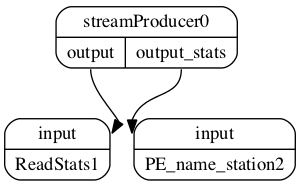

In [7]:
from dispel4py.visualisation import display
display(graph)

<h2>Exercise 2</h2>
<p>Connect the ReadStats PE to the detrend PE. Note: You have to use SimpleFunctionPE for convertiong 'detrend' function to a PE </p>

In [8]:
def detrend(st):
    st.detrend('simple')
    return st
detrendPE = SimpleFunctionPE(detrend)
graph.connect(readStats, 'output', detrendPE, 'input')

**Optional:** Visualise the extended graph.

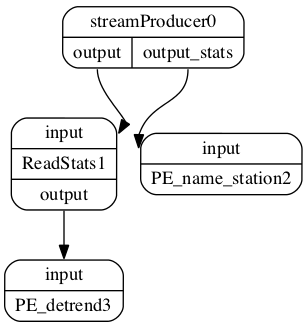

In [9]:
from dispel4py.visualisation import display
display(graph)

<h2>Exercise 3</h2> 
<p>
Execute the graph using <tt>simple_process</tt> which is the sequential mapping of dispel4py.
Because the graph reads a link of a files as the inital input data, we need to declare first and then give it to the graph. 
</p>

In [10]:
from dispel4py.new.simple_process import process as simple_process
link = 'http://escience8.inf.ed.ac.uk:8080/laquila/20100501-20120930_fseed/TERO/20100101.fseed'
input_data = {streamProducer : [ {'input' : link }]}
simple_process(graph, input_data)

Inputs: {'streamProducer0': [{'input': 'http://escience8.inf.ed.ac.uk:8080/laquila/20100501-20120930_fseed/TERO/20100101.fseed'}]}
ReadStats1:          network: IV
         station: TERO
        location: 
         channel: HHZ
       starttime: 2010-01-01T00:00:02.560000Z
         endtime: 2010-01-01T05:33:15.560000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 1999301
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'number_of_records': 2474, 'dataquality': 'D', 'byteorder': '>', 'record_length': 4096, 'encoding': 'STEIM2', 'filesize': 10133504})
Station: TERO
SimplePE: Processed 1 iteration.
Outputs: {'PE_name_station2': {'output': [Stats({'location': '', 'station': 'TERO', 'mseed': AttribDict({'number_of_records': 2474, 'dataquality': 'D', 'byteorder': '>', 'record_length': 4096, 'encoding': 'STEIM2', 'filesize': 10133504}), 'delta': 0.01, 'endtime': UTCDateTime(2010, 1, 1, 5, 33, 15, 560000), 'starttime': UTCDateTime(2010, 1, 1, 0, 0,

Simple command for executing this workflow from a terminal. 

In [11]:
!dispel4py multi xcorr_scripts/\Solution_Session_1.py -n 5 -d "{ \"streamProducer\" : [ { \"input\" : \"http://escience8.inf.ed.ac.uk:8080/laquila/20100501-20120930_fseed/TERO/20100101.fseed\" } ] }" 

Processes: {'PE_name_station2': range(4, 5), 'ReadStats1': range(2, 3), 'PE_detrend3': range(1, 2), 'SamplingRate4': range(0, 1), 'streamProducer0': range(3, 4)}
Station: TERO
PE_name_station2 (rank 4): Processed 1 iteration.
streamProducer0 (rank 3): Processed 1 iteration.
ReadStats1 (rank 2):          network: IV
         station: TERO
        location: 
         channel: HHZ
       starttime: 2010-01-01T00:00:02.560000Z
         endtime: 2010-01-01T05:33:15.560000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 1999301
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'encoding': 'STEIM2', 'dataquality': 'D', 'byteorder': '>', 'filesize': 10133504, 'number_of_records': 2474, 'record_length': 4096})
ReadStats1 (rank 2): Processed 1 iteration.
PE_detrend3 (rank 1): Processed 1 iteration.
SamplingRate4 (rank 0): Processed 1 iteration.


<h3>Note:</h3> 
<p>
If we would like to execute this graph in a shared or distributed memory machine we could use another mappings. First, you should copy the above lines (except the last 4 lines, beacuase they are needed only for using the sequential mapping) into a single script (e.g my_worklow.py). And then, execute the below lines in your command line: 
<ul>
    <li >Multiprocessing mapping for shared memory machine (several cores in the same cpu):<br/>
       <tt> dispel4py multi my_workflow -n 4\<br/>
        -d "{ \"streamProducer\" : [ { \"input\" : \"http://escience8.inf.ed.ac.uk:8080/laquila/20100501-20120930_fseed/TERO/20100101.fseed\" } ] }" </tt> </li>
    <li >MPI mapping for distributed memory machine (several cores in several cpus):<br/>
        <tt> mpiexec -n 4 dispel4py mpi my_workflow \<br/>
        -d "{ \"streamProducer\" : [ { \"input\" : \"http://escience8.inf.ed.ac.uk:8080/laquila/20100501-20120930_fseed/TERO/20100101.fseed\" } ] }" 

<h2>Exercise 4</h2> 
<p>
Create a PE (recommended: a function and a SimpleFunctionPE) called 'samplingratePE' that reads the sampling rate from the stream stats and connect it to the graph.
</p>

In [12]:
def read_samplingrate(data):
    st = data
    srate = st[0].stats['sampling_rate']
    return srate
samplingratePE = SimpleFunctionPE(read_samplingrate)
samplingratePE.name = 'SamplingRate'
graph.connect(detrendPE, 'output', samplingratePE, 'input')

**Optional:** Visualise the graph:

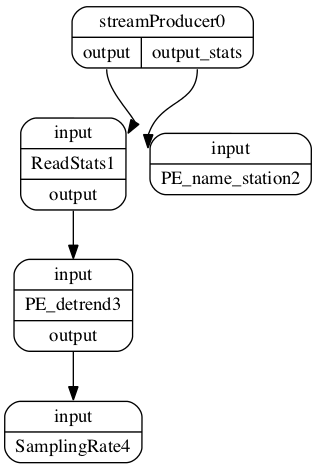

In [13]:
display(graph)

Now execute the graph:

In [14]:
input_data = {streamProducer : [ {'input' : link } ] }
simple_process(graph, input_data)

Inputs: {'streamProducer0': [{'input': 'http://escience8.inf.ed.ac.uk:8080/laquila/20100501-20120930_fseed/TERO/20100101.fseed'}]}
Station: TERO
ReadStats1:          network: IV
         station: TERO
        location: 
         channel: HHZ
       starttime: 2010-01-01T00:00:02.560000Z
         endtime: 2010-01-01T05:33:15.560000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 1999301
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'number_of_records': 2474, 'dataquality': 'D', 'byteorder': '>', 'record_length': 4096, 'encoding': 'STEIM2', 'filesize': 10133504})
SimplePE: Processed 1 iteration.
Outputs: {'PE_name_station2': {'output': [Stats({'location': '', 'station': 'TERO', 'mseed': AttribDict({'number_of_records': 2474, 'dataquality': 'D', 'byteorder': '>', 'record_length': 4096, 'encoding': 'STEIM2', 'filesize': 10133504}), 'delta': 0.01, 'endtime': UTCDateTime(2010, 1, 1, 5, 33, 15, 560000), 'starttime': UTCDateTime(2010, 1, 1, 0, 0,

<h1>Introduction to Dispel4Py</h1>
<p>
In this session you're going to write your first dispel4py workflow.
Before you start writing your own processing elements let's have a look at how a graph is created and how PEs are connected.
We have prepared two PEs that you can connect to form a simple graph.
</p>
<p>
Have a look at the PE implementations below:
The 'stream_porducer' is a function that creates an obspy stream from an input file. Later we will have to use SimpleFunctionPE() for converting that 'stream_producer' function to a PE. 
The 'ReadStats' is a PE which prints out the stats of the first trace in the stream.
Finally, the third and fourth PEs are two examples that do the same as the 'stream_producer' fuction. 
</p>